In [0]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
import collections

## Model Analysis
From our model pipeline process, using **ML Flow** we have logged and saved our model outputs. This includes, the actual model, the predictions (train + validation), and the feature importance rankings. Based on the various outputs from our train and validation we would like to evaluate and reason which model is our best performer.

##### Goal:
Choose the best model based on various performance metrics and gather it's features ranked by featured importance. From this model take note of the hyper parameters, as well as choose the top `N` number of non-colinear features.


We hope that with these finalized hyperparams and features we can build a final model that produces accurate predictions, generalizes well to unseen data, and is parsimonious

#### Documentation for metric calculations

* [Classification Report]
* [Confusion Matrix]
* [ROC_AUC]



[Classification Report]:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
[Confusion Matrix]:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
[ROC_AUC]:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

### Read the outputs from our store in DBFS

Organized into a nested dictionary structure for use throughout this report. For simplicity, we are manuallly adding the hyper parameters that were used, for each model.

##### Note: We have a separate models that were built by Devesh, to bring in his data we are storing it manually here in a dictionary to read and to populate

In [0]:
devesh_models = {}

devesh_models["rf_model_6"] = {'name': "rf_model_6", 'numTree':48,'maxDepth':12 ,'accuracy':.73,'roc_auc':.68, 'weighted avg_f1-score':.75, 'macro avg_f1-score':.64,'weighted avg_precision':.8, 'macro avg_precision':.63, 'weighted avg_recall':.73, 'macro avg_recall':.68,'weighted avg_support':701462, 'macro avg_support':.71, '0.0_f1-score':.82, '1.0_f1-score':.45, '0.0_precision':.90, '1.0_precision':.36, '0.0_recall':.76, '1.0_recall':.61, '0.0_support':577311, '1.0_support':1298351,'tn':0,'fp':0,'fn':0,'tp':0}

devesh_models["rf_model_7"] = {'name': "rf_model_7", 'numTree':52,'maxDepth':13 ,'accuracy':.73,'roc_auc':.68, 'weighted avg_f1-score':.75, 'macro avg_f1-score':.64, 'weighted avg_precision':.8, 'macro avg_precision':.63, 'weighted avg_recall':.73, 'macro avg_recall':.68,'weighted avg_support':7071462, 'macro avg_support':.71, '0.0_f1-score':.82, '1.0_f1-score':.45, '0.0_precision':.90, '1.0_precision':.36, '0.0_recall':.76, '1.0_recall':.61, '0.0_support':577311, '1.0_support':1298351, 'tn':0,'fp':0,'fn':0,'tp':0}

devesh_models["rf_model_8"] = {'name': "rf_model_8", 'numTree':56,'maxDepth':14 ,'accuracy':.73,'roc_auc':.68, 'weighted avg_f1-score':.73, 'macro avg_f1-score':.63,'weighted avg_precision':.8, 'macro avg_precision':.63, 'weighted avg_recall':.73, 'macro avg_recall':.68,'weighted avg_support':7071462, 'macro avg_support':.71, '0.0_f1-score':.82, '1.0_f1-score':.45, '0.0_precision':.89, '1.0_precision':.36, '0.0_recall':.76, '1.0_recall':.60, '0.0_support':577311, '1.0_support':1298351, 'tn':0,'fp':0,'fn':0,'tp':0}

devesh_models["rf_model_9"] = {'name': "rf_model_9", 'numTree':60,'maxDepth':15 ,'accuracy':.74,'roc_auc':.68, 'weighted avg_f1-score':.76, 'macro avg_f1-score':.64,'weighted avg_precision':.8, 'macro avg_precision':.63, 'weighted avg_recall':.74, 'macro avg_recall':.68,'weighted avg_support':7071462, 'macro avg_support':7071462, '0.0_f1-score':.83, '1.0_f1-score':.46, '0.0_precision':.89, '1.0_precision':.37, '0.0_recall':.78, '1.0_recall':.58, '0.0_support':577311, '1.0_support':1298351,'tn':0,'fp':0,'fn':0,'tp':0}

In [0]:
%%time
#Extract it all to evaluate later on.
model_versions = ['rd_model_2','rf_model_3','rf_model_4','rf_model_5',
                  'rf_model_6','rf_model_7','rf_model_8','rf_model_9',
                  'rf_model_21','rf_model_22','rf_model_24','rf_model_25',
                  'rf_model_27' ]

#Indexes align to model_versions
# i.e. (numTree, maxDepth)
meta_param = [(50,25),(30,15),(30,15),(40,15),(48,12),(52,13),(56,14),(60,15),(40,15),(40,15),(60,15),(50,18),(40,15),(40,15)]

model_meta = {}
for ind, ver in enumerate(model_versions):
    print(f"Model #{ind}: {ver}")
    feat_imp = pd.read_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{ver}/feat_imp.csv')
    if ver not in devesh_models:
        val_pred = pd.read_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{ver}/val_pred.csv')
        train_pred = pd.read_csv(f'/dbfs/mnt/mids-w261/team20SSDK/models/model_meta/{ver}/train_pred.csv')
        model_meta[ver] = {"feat_imp": feat_imp, "val_pred": val_pred, "train_pred": train_pred, "params": meta_param[ind]}
    else:
        #Devesh's models
        model_meta[ver] = {"feat_imp": feat_imp, "val_pred": "", "train_pred": "", "params": meta_param[ind]}
        

Model #0: rd_model_2
Model #1: rf_model_3
Model #2: rf_model_4
Model #3: rf_model_5
Model #4: rf_model_6
Model #5: rf_model_7
Model #6: rf_model_8
Model #7: rf_model_9
Model #8: rf_model_21
Model #9: rf_model_22
Model #10: rf_model_24
Model #11: rf_model_25
Model #12: rf_model_27
CPU times: user 2min 38s, sys: 28.2 s, total: 3min 6s
Wall time: 3min 23s

### Setup empty dataframes to track all the metrics of each model for reporting purposes.

In [0]:
train_perf = pd.DataFrame()
val_perf = pd.DataFrame()

## Confusion Matrices

**Run script to build confusion matrix for each model variant, and log all metrics for both TRAIN + VALIDATION**

All the outputs are produced for reading and understanding. The strategy that our team took to deducing our final feature set is described in the **Feature Selection** section, as well as next steps in the **Summary**.

Note for confusion matrix the breakdown is the following

| TN   |   FN |
|-------|--------|
| FP    |    TP |

Model: rd_model_2
num_tree: 50
max_depth: 25

Train Accuracy Score: 0.7493833320997875
Train F1 Score: 0.4976278955821631
Train ROC_AUC: 0.7285048906465118
 precision recall f1-score support

 0.0 0.92 0.76 0.83 13688487
 1.0 0.39 0.70 0.50 2970804

 accuracy 0.75 16659291
 macro avg 0.65 0.73 0.67 16659291
weighted avg 0.83 0.75 0.77 16659291

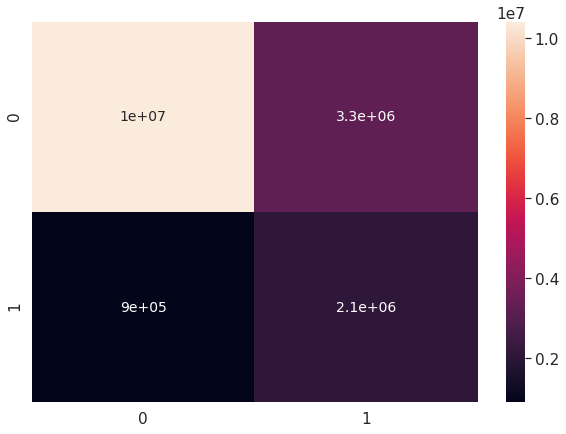

Val Accuracy Score: 0.7237838407968141
Val F1 Score: 0.4043244599035813
Val ROC_AUC: 0.6415547609152764
 precision recall f1-score support

 0.0 0.88 0.77 0.82 5730843
 1.0 0.33 0.51 0.40 1285097

 accuracy 0.72 7015940
 macro avg 0.60 0.64 0.61 7015940
weighted avg 0.78 0.72 0.74 7015940

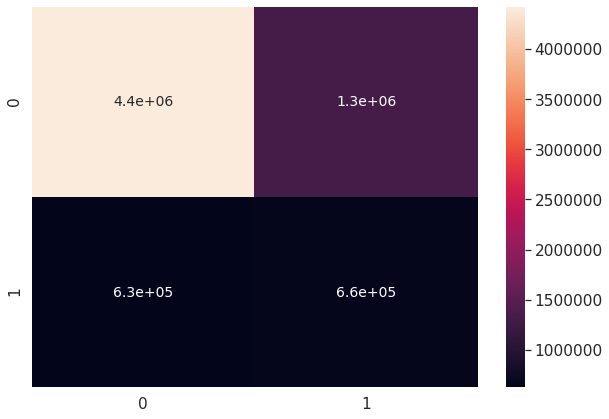

############################################################################

Model: rf_model_3
num_tree: 30
max_depth: 15

Train Accuracy Score: 0.713337500377417
Train F1 Score: 0.45295944774448005
Train ROC_AUC: 0.6946189064618042
 precision recall f1-score support

 0.0 0.91 0.72 0.81 13688487
 1.0 0.34 0.67 0.45 2970804

 accuracy 0.71 16659291
 macro avg 0.63 0.69 0.63 16659291
weighted avg 0.81 0.71 0.74 16659291

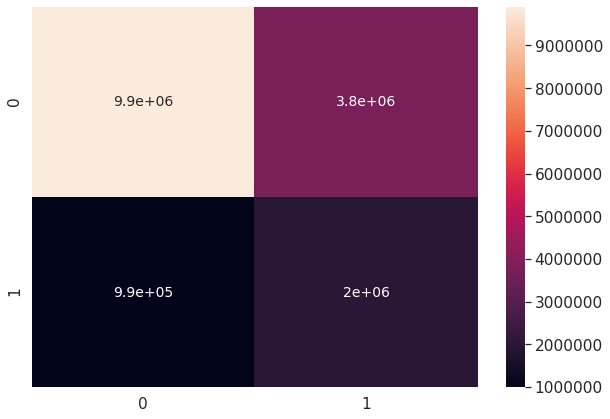

Val Accuracy Score: 0.702914933708099
Val F1 Score: 0.44743382519996194
Val ROC_AUC: 0.6849763995621307
 precision recall f1-score support

 0.0 0.90 0.71 0.80 5730843
 1.0 0.34 0.66 0.45 1285097

 accuracy 0.70 7015940
 macro avg 0.62 0.68 0.62 7015940
weighted avg 0.80 0.70 0.73 7015940

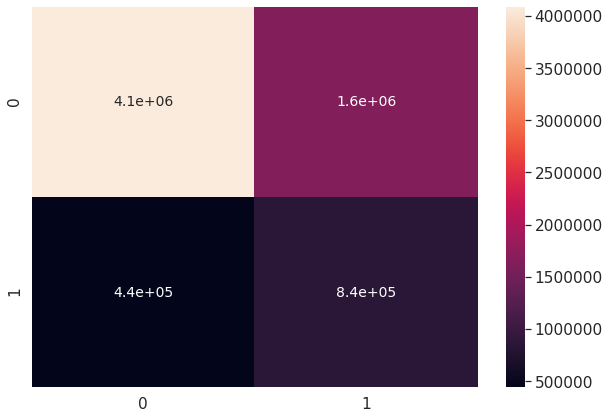

############################################################################

Model: rf_model_4
num_tree: 30
max_depth: 15

Train Accuracy Score: 0.7285247471143776
Train F1 Score: 0.46624935305876153
Train ROC_AUC: 0.703191032177894
 precision recall f1-score support

 0.0 0.91 0.74 0.82 13822766
 1.0 0.36 0.66 0.47 3006186

 accuracy 0.73 16828952
 macro avg 0.63 0.70 0.64 16828952
weighted avg 0.81 0.73 0.76 16828952

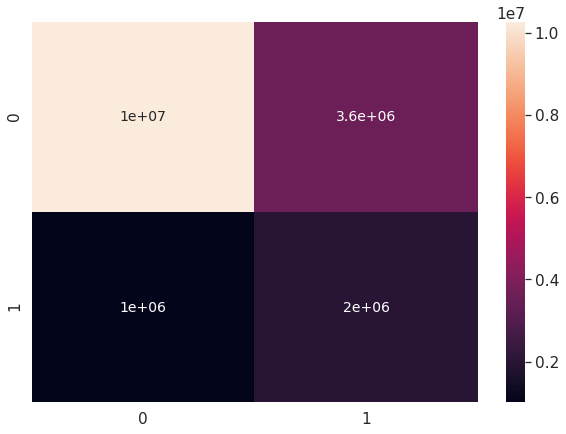

Val Accuracy Score: 0.7360142782355332
Val F1 Score: 0.4547596536776812
Val ROC_AUC: 0.6831465912650859
 precision recall f1-score support

 0.0 0.89 0.77 0.83 5773111
 1.0 0.37 0.60 0.45 1298351

 accuracy 0.74 7071462
 macro avg 0.63 0.68 0.64 7071462
weighted avg 0.80 0.74 0.76 7071462

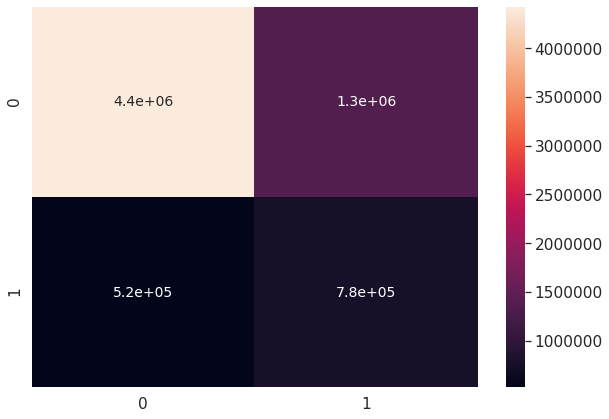

############################################################################

Model: rf_model_5
num_tree: 40
max_depth: 15

Train Accuracy Score: 0.7275603376847233
Train F1 Score: 0.46603828651460977
Train ROC_AUC: 0.7033056039223531
 precision recall f1-score support

 0.0 0.91 0.74 0.82 13822766
 1.0 0.36 0.67 0.47 3006186

 accuracy 0.73 16828952
 macro avg 0.63 0.70 0.64 16828952
weighted avg 0.81 0.73 0.75 16828952

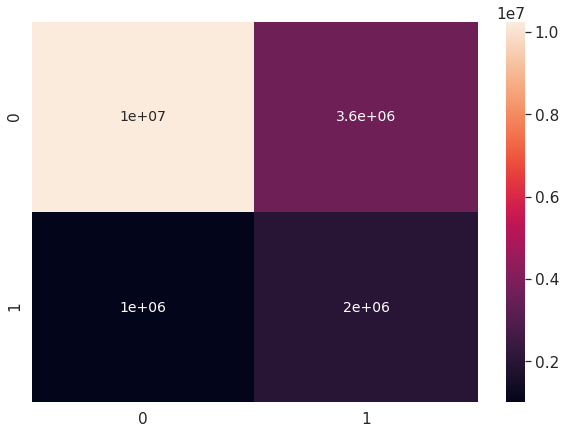

Val Accuracy Score: 0.7339970150444137
Val F1 Score: 0.45470436809332204
Val ROC_AUC: 0.6836346349826139
 precision recall f1-score support

 0.0 0.90 0.76 0.82 5773111
 1.0 0.36 0.60 0.45 1298351

 accuracy 0.73 7071462
 macro avg 0.63 0.68 0.64 7071462
weighted avg 0.80 0.73 0.76 7071462

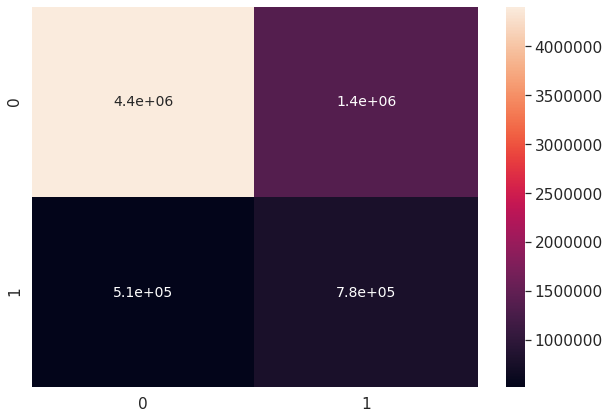

############################################################################

Model: rf_model_6
num_tree: 48
max_depth: 12

{'name': 'rf_model_6', 'numTree': 48, 'maxDepth': 12, 'accuracy': 0.73, 'roc_auc': 0.68, 'weighted avg_f1-score': 0.75, 'macro avg_f1-score': 0.64, 'weighted avg_precision': 0.8, 'macro avg_precision': 0.63, 'weighted avg_recall': 0.73, 'macro avg_recall': 0.68, 'weighted avg_support': 701462, 'macro avg_support': 0.71, '0.0_f1-score': 0.82, '1.0_f1-score': 0.45, '0.0_precision': 0.9, '1.0_precision': 0.36, '0.0_recall': 0.76, '1.0_recall': 0.61, '0.0_support': 577311, '1.0_support': 1298351, 'tn': 0, 'fp': 0, 'fn': 0, 'tp': 0}

############################################################################

Model: rf_model_7
num_tree: 52
max_depth: 13

{'name': 'rf_model_7', 'numTree': 52, 'maxDepth': 13, 'accuracy': 0.73, 'roc_auc': 0.68, 'weighted avg_f1-score': 0.75, 'macro avg_f1-score': 0.64, 'weighted avg_precision': 0.8, 'macro avg_precision': 0.63, 'weighted avg_recall': 0.73, 'macro avg_recall': 0.68, 'weighted avg_support': 7071462, 'macro avg_support': 0.71, '0.0_f1-score': 0.82, '1.0_f1-score': 0.45, '0.0_precision': 0.9, '1.0_precision': 0.36, '0.0_recall': 0.76, '1.0_recall': 0.61, '0.0_support': 577311, '1.0_support': 1298351, 'tn': 0, 'fp': 0, 'fn': 0, 'tp': 0}

############################################################################

Model: rf_model_8
num_tree: 56
max_depth: 14

{'name': 'rf_model_8', 'numTree': 56, 'maxDepth': 14, 'accuracy': 0.73, 'roc_auc': 0.68, 'weighted avg_f1-score': 0.73, 'macro avg_f1-score': 0.63, 'weighted avg_precision': 0.8, 'macro avg_precision': 0.63, 'weighted avg_recall': 0.73, 'macro avg_recall': 0.68, 'weighted avg_support': 7071462, 'macro avg_support': 0.71, '0.0_f1-score': 0.82, '1.0_f1-score': 0.45, '0.0_precision': 0.89, '1.0_precision': 0.36, '0.0_recall': 0.76, '1.0_recall': 0.6, '0.0_support': 577311, '1.0_support': 1298351, 'tn': 0, 'fp': 0, 'fn': 0, 'tp': 0}

############################################################################

Model: rf_model_9
num_tree: 60
max_depth: 15

{'name': 'rf_model_9', 'numTree': 60, 'maxDepth': 15, 'accuracy': 0.74, 'roc_auc': 0.68, 'weighted avg_f1-score': 0.76, 'macro avg_f1-score': 0.64, 'weighted avg_precision': 0.8, 'macro avg_precision': 0.63, 'weighted avg_recall': 0.74, 'macro avg_recall': 0.68, 'weighted avg_support': 7071462, 'macro avg_support': 7071462, '0.0_f1-score': 0.83, '1.0_f1-score': 0.46, '0.0_precision': 0.89, '1.0_precision': 0.37, '0.0_recall': 0.78, '1.0_recall': 0.58, '0.0_support': 577311, '1.0_support': 1298351, 'tn': 0, 'fp': 0, 'fn': 0, 'tp': 0}

############################################################################

Model: rf_model_21
num_tree: 40
max_depth: 15

Train Accuracy Score: 0.7243120070697213
Train F1 Score: 0.46013932113701284
Train ROC_AUC: 0.6982546862722483
 precision recall f1-score support

 0.0 0.91 0.74 0.81 13822766
 1.0 0.35 0.66 0.46 3006186

 accuracy 0.72 16828952
 macro avg 0.63 0.70 0.64 16828952
weighted avg 0.81 0.72 0.75 16828952

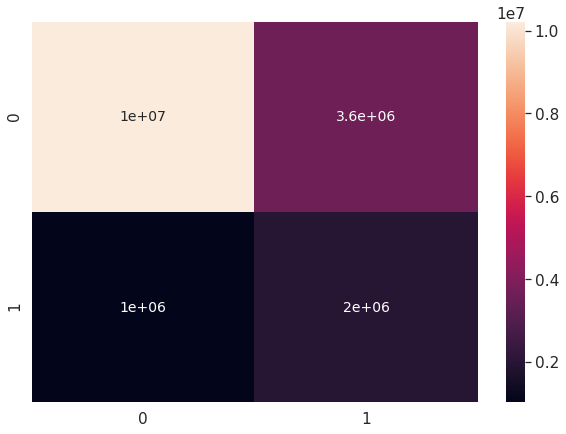

Val Accuracy Score: 0.7228549061000399
Val F1 Score: 0.4484270150224491
Val ROC_AUC: 0.6805117164479607
 precision recall f1-score support

 0.0 0.90 0.75 0.81 5773111
 1.0 0.35 0.61 0.45 1298351

 accuracy 0.72 7071462
 macro avg 0.62 0.68 0.63 7071462
weighted avg 0.80 0.72 0.75 7071462

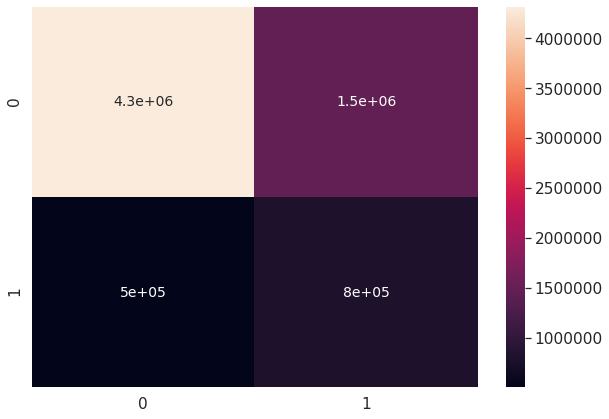

############################################################################

Model: rf_model_22
num_tree: 40
max_depth: 15

Train Accuracy Score: 0.7244275222842159
Train F1 Score: 0.45941468557178233
Train ROC_AUC: 0.6974678272914183
 precision recall f1-score support

 0.0 0.91 0.74 0.82 13822766
 1.0 0.35 0.66 0.46 3006186

 accuracy 0.72 16828952
 macro avg 0.63 0.70 0.64 16828952
weighted avg 0.81 0.72 0.75 16828952

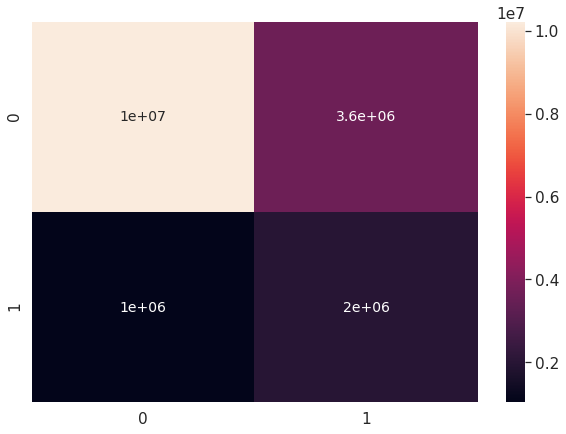

Val Accuracy Score: 0.7245240093208448
Val F1 Score: 0.4483423236467521
Val ROC_AUC: 0.6800208821076862
 precision recall f1-score support

 0.0 0.90 0.75 0.82 5773111
 1.0 0.35 0.61 0.45 1298351

 accuracy 0.72 7071462
 macro avg 0.62 0.68 0.63 7071462
weighted avg 0.80 0.72 0.75 7071462

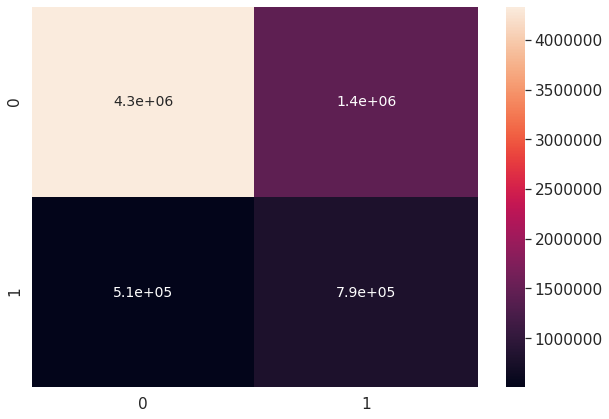

############################################################################

Model: rf_model_24
num_tree: 60
max_depth: 15

Train Accuracy Score: 0.7241274441807191
Train F1 Score: 0.45943333395432023
Train ROC_AUC: 0.6975837251625502
 precision recall f1-score support

 0.0 0.91 0.74 0.81 13822766
 1.0 0.35 0.66 0.46 3006186

 accuracy 0.72 16828952
 macro avg 0.63 0.70 0.64 16828952
weighted avg 0.81 0.72 0.75 16828952

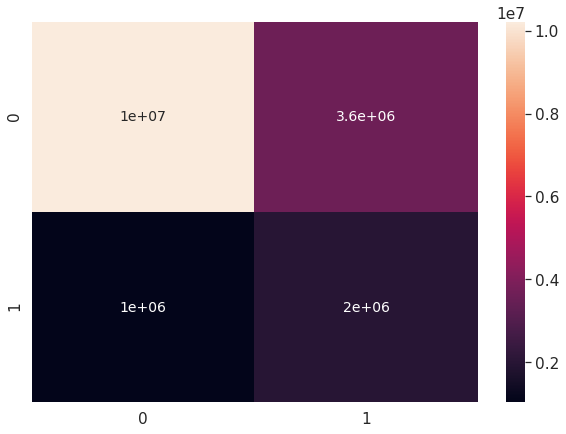

Val Accuracy Score: 0.7255762669727985
Val F1 Score: 0.4485347463317862
Val ROC_AUC: 0.6799459612787305
 precision recall f1-score support

 0.0 0.90 0.75 0.82 5773111
 1.0 0.36 0.61 0.45 1298351

 accuracy 0.73 7071462
 macro avg 0.63 0.68 0.63 7071462
weighted avg 0.80 0.73 0.75 7071462

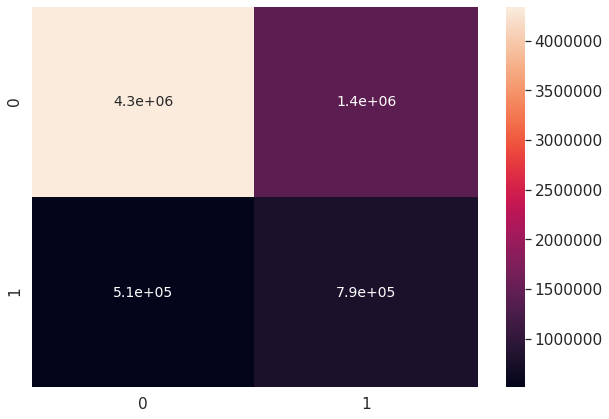

############################################################################

Model: rf_model_25
num_tree: 50
max_depth: 18

Train Accuracy Score: 0.7383719437787927
Train F1 Score: 0.47695784159456056
Train ROC_AUC: 0.710755436045959
 precision recall f1-score support

 0.0 0.91 0.75 0.83 13822766
 1.0 0.37 0.67 0.48 3006186

 accuracy 0.74 16828952
 macro avg 0.64 0.71 0.65 16828952
weighted avg 0.82 0.74 0.76 16828952

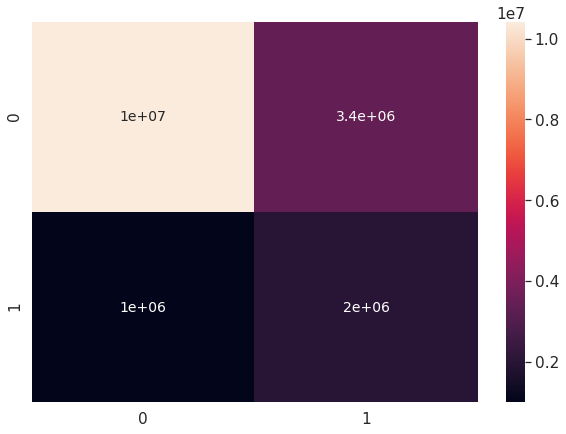

Val Accuracy Score: 0.7374827157382731
Val F1 Score: 0.4501320922770967
Val ROC_AUC: 0.6784769033001726
 precision recall f1-score support

 0.0 0.89 0.77 0.83 5773111
 1.0 0.37 0.59 0.45 1298351

 accuracy 0.74 7071462
 macro avg 0.63 0.68 0.64 7071462
weighted avg 0.80 0.74 0.76 7071462

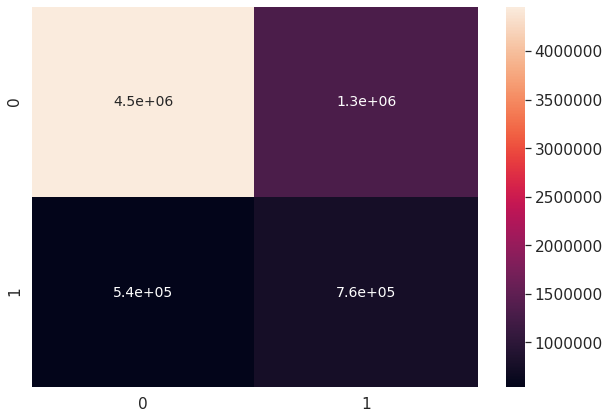

############################################################################

Model: rf_model_27
num_tree: 40
max_depth: 15

Train Accuracy Score: 0.722781311634854
Train F1 Score: 0.4579271631091624
Train ROC_AUC: 0.6964567319213426
 precision recall f1-score support

 0.0 0.91 0.74 0.81 13822766
 1.0 0.35 0.66 0.46 3006186

 accuracy 0.72 16828952
 macro avg 0.63 0.70 0.64 16828952
weighted avg 0.81 0.72 0.75 16828952

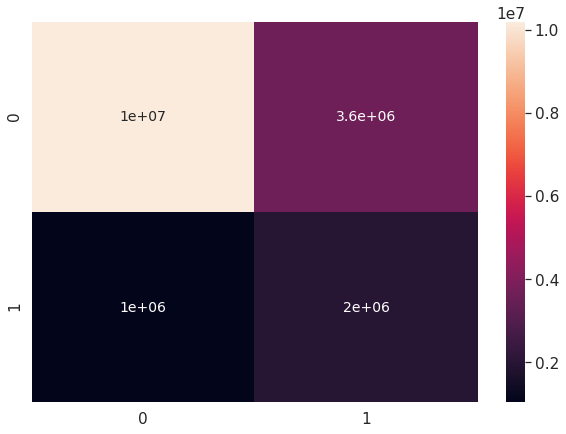

Val Accuracy Score: 0.7238266994859055
Val F1 Score: 0.44895288438233
Val ROC_AUC: 0.6807773504982464
 precision recall f1-score support

 0.0 0.90 0.75 0.82 5773111
 1.0 0.35 0.61 0.45 1298351

 accuracy 0.72 7071462
 macro avg 0.63 0.68 0.63 7071462
weighted avg 0.80 0.72 0.75 7071462

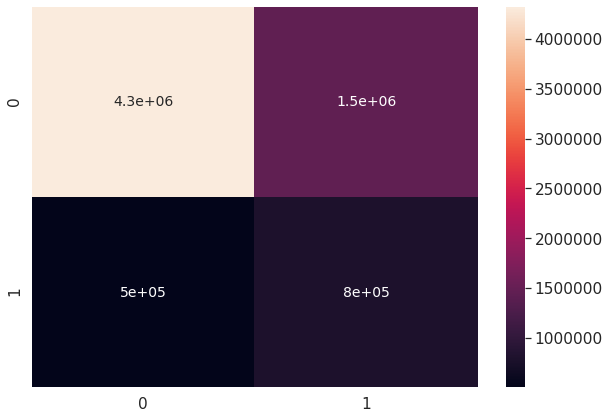

############################################################################

CPU times: user 21min 56s, sys: 2min 49s, total: 24min 46s
Wall time: 24min 41s

In [0]:
%%time

for ind, model in enumerate(model_meta):
    
    print(f"Model: {model}")
    print(f"num_tree: {model_meta[model]['params'][0]}")
    print(f"max_depth: {model_meta[model]['params'][1]}")    
    
    print()
    
    if model not in devesh_models:
        ############################################################################
        #Train    
        y_train_true = model_meta[model]["train_pred"]["label"]
        y_train_pred = model_meta[model]["train_pred"]["raw"]

        roc_auc_train = roc_auc_score(y_train_true, y_train_pred)    
        train_report = classification_report(y_train_true, y_train_pred, output_dict=True)
        print("Train Accuracy Score: ", accuracy_score(y_train_true, y_train_pred))
        print("Train F1 Score: ", f1_score(y_train_true, y_train_pred))
        print("Train ROC_AUC: ", roc_auc_train)    
        print(classification_report(y_train_true, y_train_pred))

        conf_mat_train = confusion_matrix(y_train_true, y_train_pred)    
        df_cm_train = pd.DataFrame(conf_mat_train, range(2), range(2))
        plt.figure(figsize=(10,7))
        sn.set(font_scale=1.4) # for label size
        sn.heatmap(df_cm_train, annot=True, annot_kws={"size": 14}) # font size
        plt.show()

        #Track
        train_row= pd.json_normalize(train_report, sep='_').to_dict(orient='records')[0]
        train_row["name"] = model
        train_row["numTree"] = model_meta[model]["params"][0]
        train_row["maxDepth"] = model_meta[model]["params"][1]
        train_row["tn"], train_row["fp"], train_row["fn"], train_row["tp"] = conf_mat_train.ravel()
        train_row["roc_auc"] = roc_auc_train
        train_perf = train_perf.append(train_row,True)
    
    
        ############################################################################
        #Validation
    
        y_val_true = model_meta[model]["val_pred"]["label"]
        y_val_pred = model_meta[model]["val_pred"]["raw"]

        val_report = classification_report(y_val_true, y_val_pred, output_dict=True)
        roc_auc_val = roc_auc_score(y_val_true, y_val_pred)

        print("Val Accuracy Score: ", accuracy_score(y_val_true, y_val_pred))
        print("Val F1 Score: ", f1_score(y_val_true, y_val_pred))
        print("Val ROC_AUC: ", roc_auc_val)
        print(classification_report(y_val_true, y_val_pred)) 

        conf_mat_val = confusion_matrix(y_val_true, y_val_pred)    
        df_cm_val = pd.DataFrame(conf_mat_val, range(2), range(2))
        plt.figure(figsize=(10,7))
        sn.set(font_scale=1.4) # for label size
        sn.heatmap(df_cm_val, annot=True, annot_kws={"size": 14}) # font size
        plt.show()

        #Track
        val_row = pd.json_normalize(val_report, sep='_').to_dict(orient='records')[0]
        val_row["name"] = model
        val_row["numTree"] = model_meta[model]["params"][0]
        val_row["maxDepth"] = model_meta[model]["params"][1]
        val_row["tn"], val_row["fp"], val_row["fn"], val_row["tp"] = conf_mat_val.ravel()
        val_row["roc_auc"] = roc_auc_val
        val_perf = val_perf.append(val_row,True)
    else:
        #Deveshs Metrics
        val_perf = val_perf.append(devesh_models[model],True)
        print(devesh_models[model])

    print()
    print('############################################################################')
    print()

**Reorder the columns so that they are easy to understand**

In [0]:
order_cols = ['name', 'numTree','maxDepth', 'accuracy','roc_auc', 'weighted avg_f1-score', 'macro avg_f1-score', 
              'weighted avg_precision', 'macro avg_precision', 'weighted avg_recall', 'macro avg_recall',
              'weighted avg_support', 'macro avg_support', '0.0_f1-score', '1.0_f1-score', '0.0_precision', 
              '1.0_precision', '0.0_recall', '1.0_recall', '0.0_support', '1.0_support',
              'tn','fp','fn','tp']

train_perf = train_perf[order_cols]
val_perf = val_perf[order_cols]

## Metrics Report

In [0]:
train_perf

Out[10]:

,name,numTree,maxDepth,accuracy,roc_auc,weighted avg_f1-score,macro avg_f1-score,weighted avg_precision,macro avg_precision,weighted avg_recall,macro avg_recall,weighted avg_support,macro avg_support,0.0_f1-score,1.0_f1-score,0.0_precision,1.0_precision,0.0_recall,1.0_recall,0.0_support,1.0_support,tn,fp,fn,tp
0,rd_model_2,50.0,25.0,0.749383,0.728505,0.773234,0.665338,0.825181,0.653733,0.749383,0.728505,16659291.0,16659291.0,0.833048,0.497628,0.920228,0.387238,0.760958,0.696052,13688487.0,2970804.0,10416361.0,3272126.0,902970.0,2067834.0
1,rf_model_3,30.0,15.0,0.713338,0.694619,0.742863,0.629370,0.807990,0.626074,0.713338,0.694619,16659291.0,16659291.0,0.805781,0.452959,0.908840,0.343309,0.723715,0.665523,13688487.0,2970804.0,9906558.0,3781929.0,993665.0,1977139.0
2,rf_model_4,30.0,15.0,0.728525,0.703191,0.755142,0.642110,0.811927,0.634841,0.728525,0.703191,16828952.0,16828952.0,0.817971,0.466249,0.910359,0.359322,0.742606,0.663776,13822766.0,3006186.0,10264875.0,3557891.0,1010753.0,1995433.0
3,rf_model_5,40.0,15.0,0.727560,0.703306,0.754412,0.641583,0.812005,0.634586,0.727560,0.703306,16828952.0,16828952.0,0.817127,0.466038,0.910623,0.358549,0.741042,0.665569,13822766.0,3006186.0,10243254.0,3579512.0,1005362.0,2000824.0
4,rf_model_21,40.0,15.0,0.724312,0.698255,0.751522,0.637516,0.809391,0.631155,0.724312,0.698255,16828952.0,16828952.0,0.814892,0.460139,0.908464,0.353846,0.738796,0.657713,13822766.0,3006186.0,10212203.0,3610563.0,1028977.0,1977209.0
5,rf_model_22,40.0,15.0,0.724428,0.697468,0.751548,0.637248,0.808972,0.630813,0.724428,0.697468,16828952.0,16828952.0,0.815081,0.459415,0.908001,0.353624,0.739413,0.655523,13822766.0,3006186.0,10220733.0,3602033.0,1035563.0,1970623.0
6,rf_model_24,60.0,15.0,0.724127,0.697584,0.751327,0.637121,0.809039,0.630775,0.724127,0.697584,16828952.0,16828952.0,0.814808,0.459433,0.908127,0.353424,0.738882,0.656286,13822766.0,3006186.0,10213389.0,3609377.0,1033269.0,1972917.0
7,rf_model_25,50.0,18.0,0.738372,0.710755,0.763287,0.651258,0.815785,0.641740,0.738372,0.710755,16828952.0,16828952.0,0.825558,0.476958,0.912528,0.370953,0.753723,0.667788,13822766.0,3006186.0,10418530.0,3404236.0,998690.0,2007496.0
8,rf_model_27,40.0,15.0,0.722781,0.696457,0.750206,0.635849,0.808468,0.629820,0.722781,0.696457,16828952.0,16828952.0,0.813772,0.457927,0.907769,0.351871,0.737414,0.655500,13822766.0,3006186.0,10193098.0,3629668.0,1035632.0,1970554.0


In [0]:
val_perf

Out[11]:

,name,numTree,maxDepth,accuracy,roc_auc,weighted avg_f1-score,macro avg_f1-score,weighted avg_precision,macro avg_precision,weighted avg_recall,macro avg_recall,weighted avg_support,macro avg_support,0.0_f1-score,1.0_f1-score,0.0_precision,1.0_precision,0.0_recall,1.0_recall,0.0_support,1.0_support,tn,fp,fn,tp
0,rd_model_2,50.0,25.0,0.723784,0.641555,0.744030,0.612266,0.776512,0.604933,0.723784,0.641555,7015940.0,7015940.00,0.820207,0.404324,0.875706,0.334159,0.771322,0.511787,5730843.0,1285097.0,4420328.0,1310515.0,627401.0,657696.0
1,rf_model_3,30.0,15.0,0.702915,0.684976,0.732844,0.622139,0.799407,0.620948,0.702915,0.684976,7015940.0,7015940.00,0.796845,0.447434,0.902579,0.339317,0.713286,0.656667,5730843.0,1285097.0,4087728.0,1643115.0,441216.0,843881.0
2,rf_model_4,30.0,15.0,0.736014,0.683147,0.757715,0.640304,0.797838,0.630587,0.736014,0.683147,7071462.0,7071462.00,0.825848,0.454760,0.894894,0.366280,0.766693,0.599600,5773111.0,1298351.0,4426206.0,1346905.0,519860.0,778491.0
3,rf_model_5,40.0,15.0,0.733997,0.683635,0.756272,0.639399,0.798032,0.630043,0.733997,0.683635,7071462.0,7071462.00,0.824094,0.454704,0.895516,0.364569,0.763222,0.604047,5773111.0,1298351.0,4406167.0,1366944.0,514086.0,784265.0
4,rf_model_6,48.0,12.0,0.730000,0.680000,0.750000,0.640000,0.800000,0.630000,0.730000,0.680000,701462.0,0.71,0.820000,0.450000,0.900000,0.360000,0.760000,0.610000,577311.0,1298351.0,0.0,0.0,0.0,0.0
5,rf_model_7,52.0,13.0,0.730000,0.680000,0.750000,0.640000,0.800000,0.630000,0.730000,0.680000,7071462.0,0.71,0.820000,0.450000,0.900000,0.360000,0.760000,0.610000,577311.0,1298351.0,0.0,0.0,0.0,0.0
6,rf_model_8,56.0,14.0,0.730000,0.680000,0.730000,0.630000,0.800000,0.630000,0.730000,0.680000,7071462.0,0.71,0.820000,0.450000,0.890000,0.360000,0.760000,0.600000,577311.0,1298351.0,0.0,0.0,0.0,0.0
7,rf_model_9,60.0,15.0,0.740000,0.680000,0.760000,0.640000,0.800000,0.630000,0.740000,0.680000,7071462.0,7071462.00,0.830000,0.460000,0.890000,0.370000,0.780000,0.580000,577311.0,1298351.0,0.0,0.0,0.0,0.0
8,rf_model_21,40.0,15.0,0.722855,0.680512,0.747641,0.631680,0.796234,0.624581,0.722855,0.680512,7071462.0,7071462.00,0.814933,0.448427,0.895843,0.353319,0.747427,0.613597,5773111.0,1298351.0,4314977.0,1458134.0,501687.0,796664.0
9,rf_model_22,40.0,15.0,0.724524,0.680021,0.748846,0.632385,0.795985,0.624895,0.724524,0.680021,7071462.0,7071462.00,0.816428,0.448342,0.895268,0.354521,0.750349,0.609693,5773111.0,1298351.0,4331849.0,1441262.0,506756.0,791595.0


### False Positive Analysis:

As we look at our metrics, we seee that we have a consistent issue in predicting **FP**'s, we take a deeper dive into this in the following [notebook]
* Prediction Probabilities
* Flight/Weather Trends

[notebook]:https://deerlab.com/images/uploads/blog/98/omg.gif

In [0]:
# # #Store them for easy access later on
# train_perf.to_csv(f'/dbfs/mnt/mids-w261/team20SSDK/reports/train_perf.csv', index=False)
# val_perf.to_csv(f'/dbfs/mnt/mids-w261/team20SSDK/reports/val_perf.csv', index=False)

### Feature Importance

Study the features ranked by importance for each Random Forest model run

In [0]:
%%time
for model in model_meta:
    print(f"Model: {model}")
    print(f"num_tree: {model_meta[model]['params'][0]}")
    print(f"max_depth: {model_meta[model]['params'][1]}")
    print(model_meta[model]['feat_imp'].head(20))
    print()

Model: rd_model_2
num_tree: 50
max_depth: 25
 idx name score order
0 4 DELAYS_SO_FAR 0.276054 1
1 6 AVG_WND_SPEED_ORIGIN 0.033328 2
2 14 AVG_WND_SPEED_DEST 0.030614 3
3 793 DEP_HOUR_catVec_6 0.029792 4
4 11 AVG_TMP_DEG_ORIGIN 0.026060 5
5 19 AVG_TMP_DEG_DEST 0.019503 6
6 12 AVG_DEW_DEG_ORIGIN 0.019029 7
7 7 AVG_CIG_HEIGHT_ORIGIN 0.018695 8
8 15 AVG_CIG_HEIGHT_DEST 0.016018 9
9 9 AVG_VIS_DIS_ORIGIN 0.015002 10
10 794 DEP_HOUR_catVec_7 0.014643 11
11 37 ARR_HOUR_catVec_8 0.014506 12
12 0 ORIGIN_FLIGHT_COUNT 0.014058 13
13 32 ARR_HOUR_catVec_9 0.013290 14
14 13 AVG_SLP_ORIGIN 0.012951 15
15 10 MIN_VIS_DIS_ORIGIN 0.012680 16
16 17 AVG_VIS_DIS_DEST 0.012049 17
17 2 PAGERANK 0.011834 18
18 20 AVG_DEW_DEG_DEST 0.011454 19
19 810 DEP_HOUR_catVec_5 0.011179 20

Model: rf_model_3
num_tree: 30
max_depth: 15
 idx name score order
0 0 DELAYS_SO_FAR 0.401848 1
1 20 MINUTES_AFTER_MIDNIGHT_ORIGIN 0.067744 2
2 21 MINUTES_AFTER_MIDNIGHT_DEST 0.066640 3
3 76 DEP_HOUR_BIN_catVec_1 0.064207 4
4 74 DEP_HOUR_BIN_catVec_3 0.027136 5
5 22 DEP_HOUR_catVec_6 0.026125 6
6 1 AVG_WND_SPEED_ORIGIN 0.024229 7
7 2 AVG_WND_SPEED_DEST 0.020848 8
8 3 AVG_TMP_DEG_ORIGIN 0.018593 9
9 8 AVG_VIS_DIS_ORIGIN 0.016736 10
10 5 AVG_DEW_DEG_ORIGIN 0.015892 11
11 6 AVG_CIG_HEIGHT_ORIGIN 0.014422 12
12 9 ORIGIN_FLIGHT_COUNT 0.014095 13
13 11 MIN_VIS_DIS_ORIGIN 0.014029 14
14 12 AVG_VIS_DIS_DEST 0.013815 15
15 13 PAGERANK 0.013649 16
16 18 CRS_ELAPSED_TIME 0.013098 17
17 4 AVG_TMP_DEG_DEST 0.012847 18
18 7 AVG_CIG_HEIGHT_DEST 0.012667 19
19 75 DEP_HOUR_BIN_catVec_2 0.012196 20

Model: rf_model_4
num_tree: 30
max_depth: 15
 idx name score order
0 0 DELAYS_SO_FAR 0.410439 1
1 22 MINUTES_AFTER_MIDNIGHT_DEST 0.072155 2
2 21 MINUTES_AFTER_MIDNIGHT_ORIGIN 0.062139 3
3 26 DEP_HOUR_BIN_catVec_1 0.054651 4
4 31 ARR_HOUR_BIN_catVec_1 0.035435 5
5 24 DEP_HOUR_BIN_catVec_3 0.032671 6
6 23 NETWORK_CONGESTION 0.032215 7
7 8 AVG_VIS_DIS_ORIGIN 0.017344 8
8 14 DEST_PR 0.016952 9
9 13 ORIGIN_PR 0.016818 10
10 30 ARR_HOUR_BIN_catVec_2 0.016505 11
11 5 AVG_DEW_DEG_ORIGIN 0.016017 12
12 19 CRS_ELAPSED_TIME 0.014299 13
13 9 ORIGIN_FLIGHT_COUNT 0.014122 14
14 6 AVG_CIG_HEIGHT_ORIGIN 0.013963 15
15 3 AVG_TMP_DEG_ORIGIN 0.013781 16
16 12 AVG_VIS_DIS_DEST 0.013760 17
17 2 AVG_WND_SPEED_DEST 0.013676 18
18 11 MIN_VIS_DIS_ORIGIN 0.013649 19
19 7 AVG_CIG_HEIGHT_DEST 0.012877 20

Model: rf_model_5
num_tree: 40
max_depth: 15
 idx name score order
0 0 DELAYS_SO_FAR 0.404010 1
1 22 MINUTES_AFTER_MIDNIGHT_DEST 0.075356 2
2 21 MINUTES_AFTER_MIDNIGHT_ORIGIN 0.070390 3
3 26 DEP_HOUR_BIN_catVec_1 0.059287 4
4 31 ARR_HOUR_BIN_catVec_1 0.034884 5
5 23 NETWORK_CONGESTION 0.031673 6
6 24 DEP_HOUR_BIN_catVec_3 0.021868 7
7 13 ORIGIN_PR 0.017575 8
8 5 AVG_DEW_DEG_ORIGIN 0.016532 9
9 14 DEST_PR 0.016510 10
10 3 AVG_TMP_DEG_ORIGIN 0.016074 11
11 8 AVG_VIS_DIS_ORIGIN 0.015454 12
12 11 MIN_VIS_DIS_ORIGIN 0.015373 13
13 19 CRS_ELAPSED_TIME 0.014317 14
14 9 ORIGIN_FLIGHT_COUNT 0.013802 15
15 1 AVG_WND_SPEED_ORIGIN 0.013794 16
16 7 AVG_CIG_HEIGHT_DEST 0.013480 17
17 6 AVG_CIG_HEIGHT_ORIGIN 0.013465 18
18 12 AVG_VIS_DIS_DEST 0.013164 19
19 2 AVG_WND_SPEED_DEST 0.012809 20

Model: rf_model_6
num_tree: 48
max_depth: 12
 {12: idx name score
0 14 14 DELAYS_SO_FAR 0.380396
1 40 40 DEP_HOUR_BIN_catVec_1 0.075521
2 24 24 ARR_HOUR_BIN_catVec_1 0.064367
3 11 11 AVG_WND_SPEED_ORIGIN 0.040339
4 21 21 NETWORK_CONGESTION 0.040321
5 25 25 ARR_HOUR_BIN_catVec_4 0.039778
6 38 38 DEP_HOUR_BIN_catVec_3 0.036893
7 23 23 ARR_HOUR_BIN_catVec_2 0.027074
8 10 10 AVG_WND_SPEED_DEST 0.026524
9 22 22 ARR_HOUR_BIN_catVec_3 0.025484
10 7 7 AVG_TMP_DEG_ORIGIN 0.017469
11 76 76 OP_CARRIER_catVec_WN 0.017277
12 41 41 DEP_HOUR_BIN_catVec_4 0.015505
13 19 19 ORIGIN_PR 0.014305
14 9 9 AVG_VIS_DIS_ORIGIN 0.013332
15 1 1 AVG_CIG_HEIGHT_ORIGIN 0.011731
16 39 39 DEP_HOUR_BIN_catVec_2 0.011531
17 3 3 AVG_DEW_DEG_ORIGIN 0.011356
18 6 6 AVG_TMP_DEG_DEST 0.011305
19 0 0 AVG_CIG_HEIGHT_DEST 0.011244

Model: rf_model_7
num_tree: 52
max_depth: 13
 13:00 idx name score


## Feature Selection

Now that we have reports on various metrics for all the **Random Forest** models that we have run, it is time to really hone in on the features that we've given the model. Throughout the modelling phase we have experimented with hyper parameters as well as features based on our research and EDA. Looking at the feature importance reports we can quickly get a gauge on what features consistently make it to the top.

As we consider these top features we must be mindful of collinearity amongst these features; by avoiding collinearity we will ensure that the model is not giving more importance to any given facet of the data. We will make sure to reduce noise as well as make our model more parsimonious and explainable by cutting down on the feature set.

### Correlation Matrix
Build a correlation matrix on all our numerical features to get an understanding of collinearity. By studying the correlations side-by-side with the feature importance tables, we can justify which feature to select when it comes to collinear scenarios.

In [0]:
train_data = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/team20SSDK/project_data/train/part-00*.parquet")
print("Train Data: ", train_data.count())

Train Data: 16828952

In [0]:
num_cols = ['DELAYS_SO_FAR','AVG_WND_SPEED_ORIGIN','AVG_WND_SPEED_DEST','AVG_TMP_DEG_ORIGIN',
            'AVG_TMP_DEG_DEST', 'AVG_DEW_DEG_ORIGIN', 'AVG_CIG_HEIGHT_ORIGIN', 'AVG_CIG_HEIGHT_DEST',
            'AVG_VIS_DIS_ORIGIN', 'ORIGIN_FLIGHT_COUNT', 'AVG_SLP_ORIGIN', 'MIN_VIS_DIS_ORIGIN',
            'AVG_VIS_DIS_DEST','ORIGIN_PR','DEST_PR','AVG_DEW_DEG_DEST', 'MIN_CIG_HEIGHT_ORIGIN',
            'DEST_FLIGHT_COUNT', 'AVG_SLP_DEST','CRS_ELAPSED_TIME', 'CRS_ELAPSED_TIME_AVG_DIFF',
            'MINUTES_AFTER_MIDNIGHT_ORIGIN', 'MINUTES_AFTER_MIDNIGHT_DEST', 'NETWORK_CONGESTION']

train_trim = train_data.select(*num_cols).toPandas()
print("Train Shape ", train_trim.shape)

Train Shape (16828952, 24)

The correlation matrix below points out some distinct cases of collinearity. For example the `ORIGIN_PR` (origin airport pagerank) and the `ORIGIN_FLIGHT_COUNT` a extremely high correlation. When we compare this to the feature importance tables overall, we can see that the `ORIGIN_PR` ranks higher in the Random Forest, therefore we can justify that we will drop the feature `ORIGIN_FLIGHT_COUNT`.

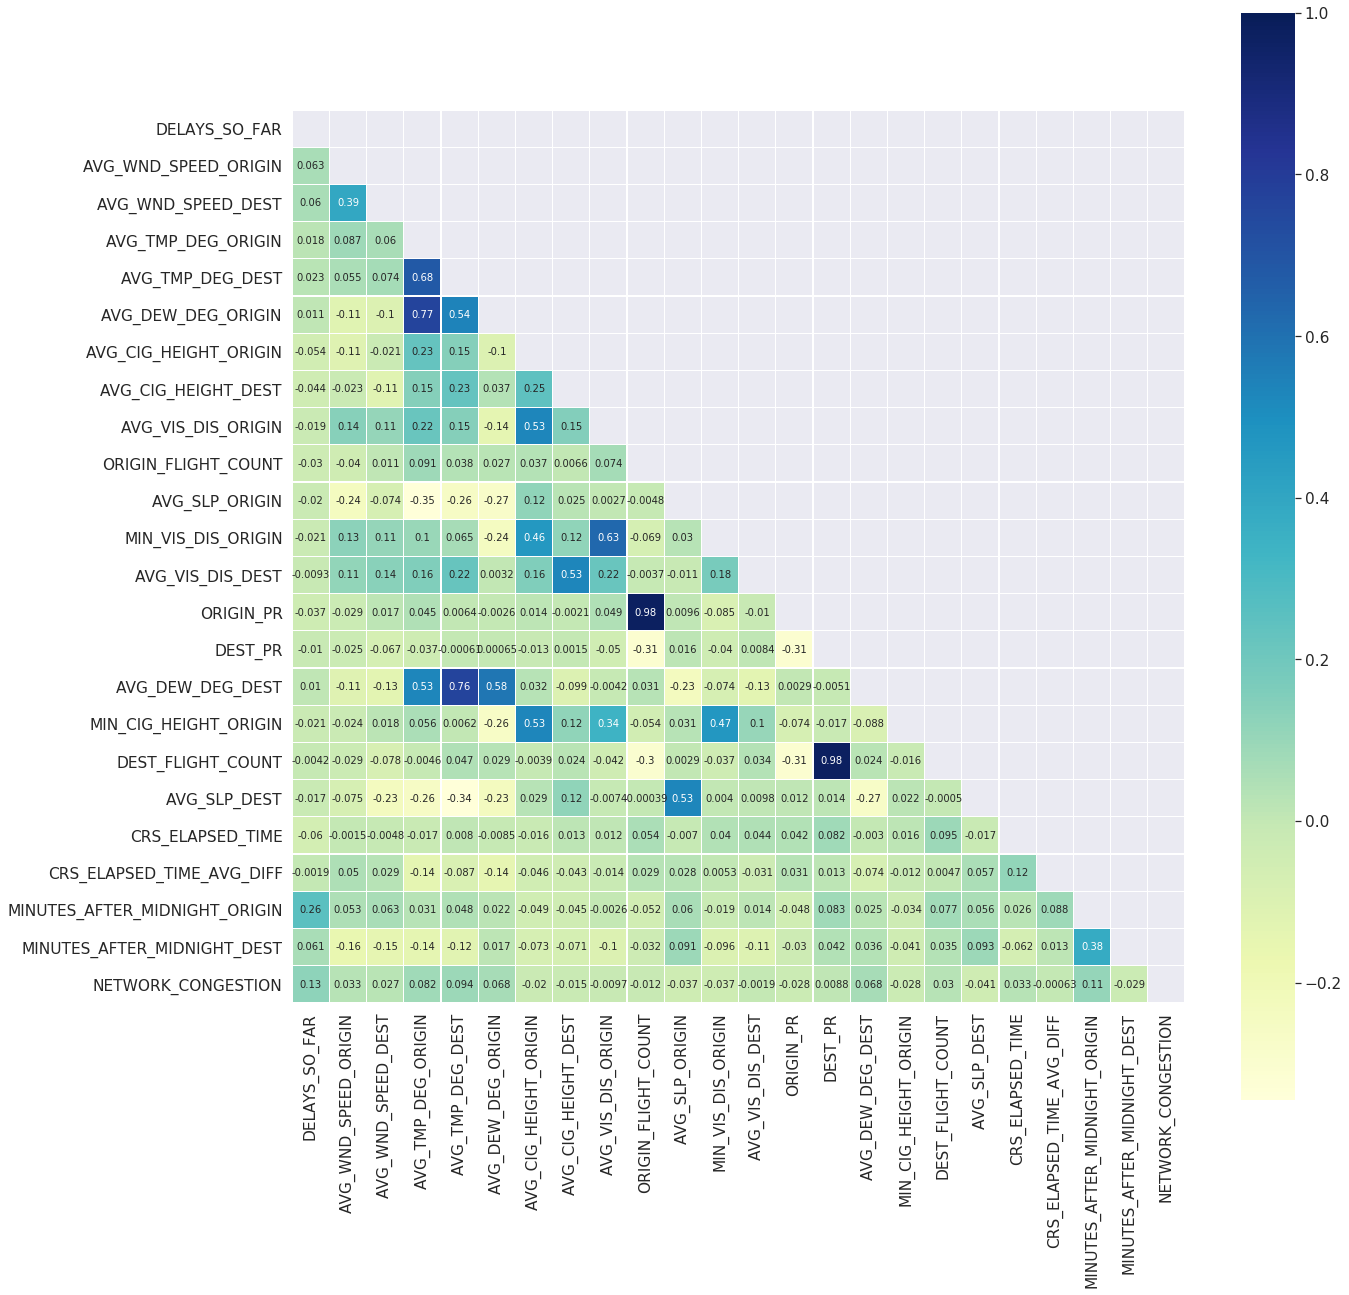

In [0]:
trainCorrMatrix = train_trim.corr()

# Generate a mask for the upper triangle
mask_train = np.triu(np.ones_like(trainCorrMatrix, dtype=bool))

f = plt.figure(figsize=(20, 20))
sn.heatmap(trainCorrMatrix, square=True, mask=mask_train, cmap="YlGnBu", linewidths=0.1, annot=True, annot_kws={"fontsize":10})  
plt.show()

### Just focus on the top ~15ish features
Because we want to reduce collinearity in our **top features**, we will consider the top 15 features based on `feature_imp` score that we have stored in our **models_meta** dictionary for each model variant.

In [0]:
feature_names = set()
for model in model_meta:
    feature_names.update(list(model_meta[model]['feat_imp'][0:15]["name"]))
print("NUmber of feature columns: ", len(feature_names))

NUmber of feature columns: 32

`32` represents the total number of features columns that reflects OHE columns, therefore we have to do some manual intervention to map those `32` to actual feature columns. Ultimately focussing on the numerical features we result in `19` that we can study below.

In [0]:
#Manually cut away
top_num_features = ['AVG_WND_SPEED_DEST', 'DEST_PR', 'AVG_VIS_DIS_ORIGIN', 'AVG_TMP_DEG_ORIGIN',
                    'AVG_TMP_DEG_DEST', 'NETWORK_CONGESTION', 'AVG_SLP_ORIGIN',
                    'ORIGIN_FLIGHT_COUNT', 'AVG_CIG_HEIGHT_ORIGIN', 'AVG_WND_SPEED_ORIGIN',
                    'MINUTES_AFTER_MIDNIGHT_ORIGIN', 'MINUTES_AFTER_MIDNIGHT_DEST', 'AVG_DEW_DEG_ORIGIN',
                    'MIN_VIS_DIS_ORIGIN', 'AVG_VIS_DIS_DEST', 'DELAYS_SO_FAR', 'ORIGIN_PR', 'AVG_CIG_HEIGHT_DEST', 'CRS_ELAPSED_TIME']

len(top_num_features)

Out[74]: 19

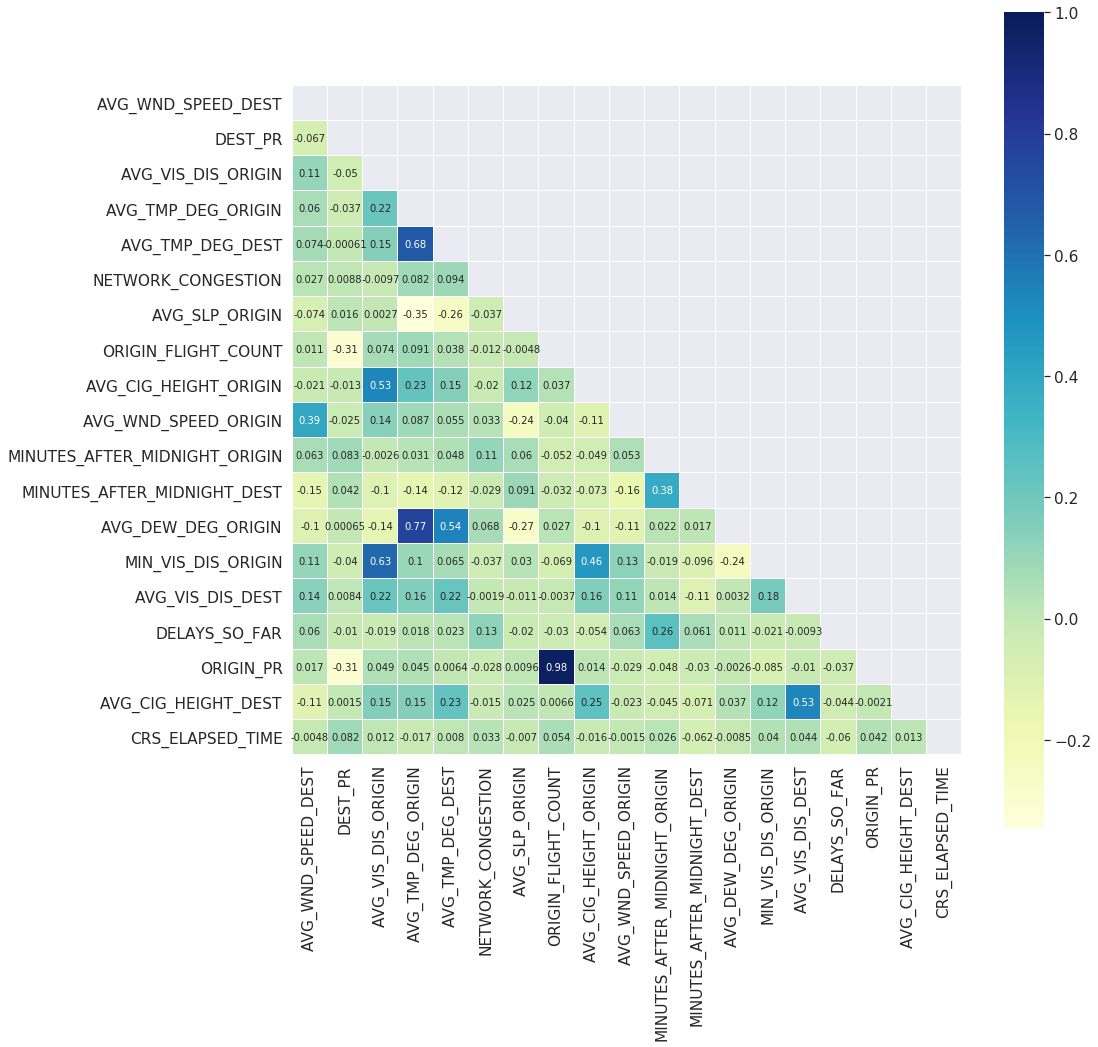

In [0]:
train_top = train_trim[top_num_features]
trainCorrMatrix = train_top.corr()

# Generate a mask for the upper triangle
mask_train = np.triu(np.ones_like(trainCorrMatrix, dtype=bool))

f = plt.figure(figsize=(15, 15))
sn.heatmap(trainCorrMatrix, square=True, mask=mask_train, cmap="YlGnBu", linewidths=0.1, annot=True, annot_kws={"fontsize":10})  
plt.show()

### Group by the features that show up most in the top 15 across our models

**Grain of salt** for the below results Not all features were used in all models therefore some features may automatically show up lower based off counts.

In [0]:
feat_imp_top_track = {}
for model in model_meta:
    feats = list(model_meta[model]['feat_imp'][0:15]["name"])
    for feat in feats:
        if feat in feat_imp_top_track:
            feat_imp_top_track[feat] += 1
        else:
            feat_imp_top_track[feat]= 1
od = collections.OrderedDict(sorted(feat_imp_top_track.items()))

# print(od)
top_feat_by_count = [('ARR_HOUR_BIN_catVec_1', 6),
             ('ARR_HOUR_BIN_catVec_2', 5),
             ('ARR_HOUR_BIN_catVec_3', 4),
             ('ARR_HOUR_BIN_catVec_4', 4),
             ('ARR_HOUR_catVec_8', 1),
             ('ARR_HOUR_catVec_9', 1),
             ('AVG_CIG_HEIGHT_DEST', 1),
             ('AVG_CIG_HEIGHT_ORIGIN', 4),
             ('AVG_DEW_DEG_ORIGIN', 4),
             ('AVG_SLP_ORIGIN', 1),
             ('AVG_TMP_DEG_DEST', 1),
             ('AVG_TMP_DEG_ORIGIN', 7),
             ('AVG_VIS_DIS_DEST', 1),
             ('AVG_VIS_DIS_ORIGIN', 7),
             ('AVG_WND_SPEED_DEST', 6),
             ('AVG_WND_SPEED_ORIGIN', 6),
             ('CRS_ELAPSED_TIME', 2),
             ('DELAYS_SO_FAR', 8),
             ('DEP_HOUR_BIN_catVec_1', 7),
             ('DEP_HOUR_BIN_catVec_2', 2),
             ('DEP_HOUR_BIN_catVec_3', 7),
             ('DEP_HOUR_BIN_catVec_4', 2),
             ('DEP_HOUR_catVec_6', 2),
             ('DEP_HOUR_catVec_7', 1),
             ('DEST_PR', 2),
             ('MINUTES_AFTER_MIDNIGHT_DEST', 3),
             ('MINUTES_AFTER_MIDNIGHT_ORIGIN', 3),
             ('MIN_VIS_DIS_ORIGIN', 2),
             ('NETWORK_CONGESTION', 6),
             ('OP_CARRIER_catVec_WN', 4),
             ('ORIGIN_FLIGHT_COUNT', 4),
             ('ORIGIN_PR', 6)]

top_feat_by_count = sorted(top_feat_by_count, key= lambda x: -x[1])


In [0]:
top_feat_by_count

Out[27]: [('DELAYS_SO_FAR', 8),
 ('AVG_TMP_DEG_ORIGIN', 7),
 ('AVG_VIS_DIS_ORIGIN', 7),
 ('DEP_HOUR_BIN_catVec_1', 7),
 ('DEP_HOUR_BIN_catVec_3', 7),
 ('ARR_HOUR_BIN_catVec_1', 6),
 ('AVG_WND_SPEED_DEST', 6),
 ('AVG_WND_SPEED_ORIGIN', 6),
 ('NETWORK_CONGESTION', 6),
 ('ORIGIN_PR', 6),
 ('ARR_HOUR_BIN_catVec_2', 5),
 ('ARR_HOUR_BIN_catVec_3', 4),
 ('ARR_HOUR_BIN_catVec_4', 4),
 ('AVG_CIG_HEIGHT_ORIGIN', 4),
 ('AVG_DEW_DEG_ORIGIN', 4),
 ('OP_CARRIER_catVec_WN', 4),
 ('ORIGIN_FLIGHT_COUNT', 4),
 ('MINUTES_AFTER_MIDNIGHT_DEST', 3),
 ('MINUTES_AFTER_MIDNIGHT_ORIGIN', 3),
 ('CRS_ELAPSED_TIME', 2),
 ('DEP_HOUR_BIN_catVec_2', 2),
 ('DEP_HOUR_BIN_catVec_4', 2),
 ('DEP_HOUR_catVec_6', 2),
 ('DEST_PR', 2),
 ('MIN_VIS_DIS_ORIGIN', 2),
 ('ARR_HOUR_catVec_8', 1),
 ('ARR_HOUR_catVec_9', 1),
 ('AVG_CIG_HEIGHT_DEST', 1),
 ('AVG_SLP_ORIGIN', 1),
 ('AVG_TMP_DEG_DEST', 1),
 ('AVG_VIS_DIS_DEST', 1),
 ('DEP_HOUR_catVec_7', 1)]

## Summary

Looking at the `train_perf` some trends in modelling become very clear. As we increase the hyper parameter `numTrees` we see an improvement in our model, there is a steady increase that is also a reflection of `maxDepth`. We have to be mindful of the business problem we are trying to solve. Our assumption is that incorrectly predicting a delay when in fact a flight is on time should be penalized; i.e. predicting a false positive. We would like to ride on the conservative side, because this way in the worst case a traveller may be disgruntled due to a delay, instead of extremeley upset because they missed their flight due to our prediction.

Therefore the metrics that we are looking to optimize on are **1.0_precision** (delay class), **accuracy**, and **weighted avg_precision**(accounts for class imbalance). Therefore from our models we see models **#4**, **#5**, and **#9** as our top performers. After identifying these, we focus on what features make it into the respective `top_15` for each model. We cross validate these features with the `top_feat_by_count` as sanity check that a feature makes it into the top 15 across multiple models.

Finally from this subset we will end up having both categorical and numerical features. From the numerical features, we can then study the correlation matrix, to choose features that are not collinear with each other, ultimately giving us a chance to capture the variance of the problem space. By picking features that don't overlap with one another we can conceptually represent many things, such as:
* Weather
* Time of Day
* Propagation Delay
* Airport Popularity
* Network Congestion
* Estimated Trip Durations.

This gives our model a well rounded, parsimonious feature set that we hope to see improve our key performance metrics.

### Final Features

The **numerical features** listed below are all described above, and can be found in the correlation matrix below.

The **categorical features** all stem from behavior we have seen in the departure hour during the day, and the flight behavior we see across quarterly segments during the year. We noticed that specifc hour ranges during the day are associated to unique behavior in delay uptic, and delay plateau'ing, therefore we will be creating two new boolean features on the fly for our final model.

If a flight is leaving between 6 AM - 9 AM, `IS_MORNING_FLIGHT` will be **TRUE**l if a flight is leaving between 3 PM - 8 PM, `IS_EVENING_FLIGHT` will be **TRUE**. Otherwise respectively the values will be **FALSE**.

In [0]:
final_num = ['DELAYS_SO_FAR', 'MINUTES_AFTER_MIDNIGHT_ORIGIN','MINUTES_AFTER_MIDNIGHT_DEST',
                 'NETWORK_CONGESTION','AVG_VIS_DIS_ORIGIN','DEST_PR','ORIGIN_PR', 'AVG_DEW_DEG_ORIGIN',
                 'CRS_ELAPSED_TIME', 'AVG_WND_SPEED_ORIGIN','AVG_WND_SPEED_DEST',            
            ]

final_cat = ['QUARTER', 'IS_MORNING_FLIGHT', 'IS_EVENING_FLIGHT']

### Correlation Matrix (pt.2)
As you can see here, with the final numerical features we have selected we have very much improved upon the correlation between features, thus avoiding collinearity. As per the categorical features, we have limited

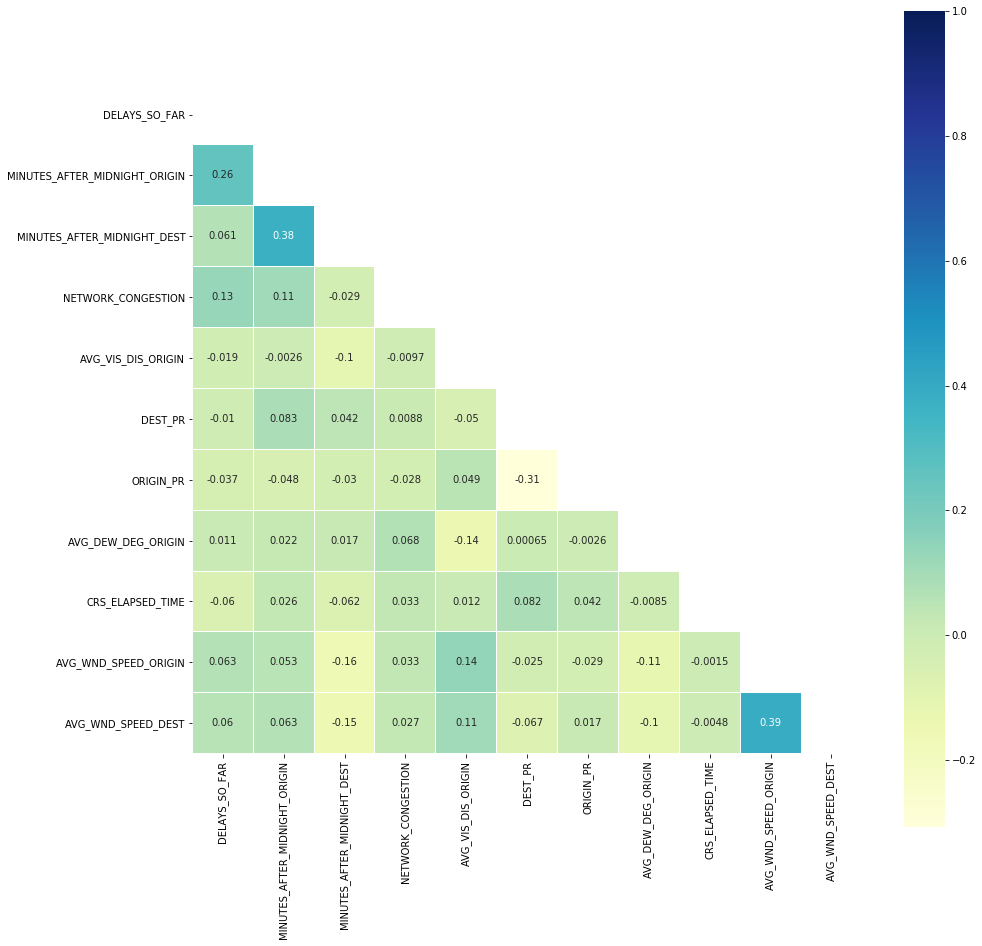

In [0]:
train_top_fin = train_trim[final_num]
val_top_fin = val_trim[final_num]
trainCorrMatrix = train_top_fin.corr()

# Generate a mask for the upper triangle
mask_train = np.triu(np.ones_like(trainCorrMatrix, dtype=bool))

f = plt.figure(figsize=(15, 15))
sn.heatmap(trainCorrMatrix, square=True, mask=mask_train, cmap="YlGnBu", linewidths=0.1, annot=True, annot_kws={"fontsize":10})  
plt.show()

### Next Steps

Now that we have all our features finalized we will take this onto our final round of modelling with **Random Forests** and **Gradient Boosted Trees**. After trying a few different

In [0]:
model_meta['rd_model_2']['feat_imp'].head(20)

Out[5]:

,idx,name,score,order
0,4,DELAYS_SO_FAR,0.276054,1
1,6,AVG_WND_SPEED_ORIGIN,0.033328,2
2,14,AVG_WND_SPEED_DEST,0.030614,3
3,793,DEP_HOUR_catVec_6,0.029792,4
4,11,AVG_TMP_DEG_ORIGIN,0.026060,5
5,19,AVG_TMP_DEG_DEST,0.019503,6
6,12,AVG_DEW_DEG_ORIGIN,0.019029,7
7,7,AVG_CIG_HEIGHT_ORIGIN,0.018695,8
8,15,AVG_CIG_HEIGHT_DEST,0.016018,9
9,9,AVG_VIS_DIS_ORIGIN,0.015002,10
